Заведем системные функции

In [284]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [285]:
N_GRAPH = 1000

In [286]:
def get_xs(xl, xr, n):
    if n == 1:
        return np.array([xl])
    s = (xr - xl) / (n - 1)
    return np.arange(xl, xr + 10 ** -9, s)

In [287]:
def get_diff(xs, f1, f2):
    return list(map(lambda x: abs(f1(x) - f2(x)), xs))

In [288]:
def draw(xs, ys, names=None):
    if type(xs) is not list:
        xs = [xs]
        ys = [ys]
        if names is not None:
            names = [names]
            
    n = len(xs)
    for i in range(n):
        plt.plot(xs[i], ys[i])
        
    if names is not None:
        plt.legend(names)
    plt.show()

# Задание 7

Решим диффиринциальное уравнение:
$$-u''(x) + u(x) = x, 0 \leq x \leq 1, u(0)=u(1)=0$$
Однородное уравнение:
$$x^2 - 1 = 0$$
Корни уравнения ${-1, 1}$. Значит общий вид:
$$u(x) = C_1 e^x + C_2 e^{-x}$$
Также имеем частное решение $u(x) = x$ неоднородного уравнения:
$$-u''(x) + u(x) = x$$
В итоге получаем:
$$u(x) = C_1 e^x + C_2 e^{-x} + x$$
Из условий задачи находи константы:
$$C_1 = \frac{e}{1 - e^2}, C_1 = \frac{e}{e^2 - 1}$$
Ответ:
$$u(x) = \frac{e}{1 - e^2} e^x + \frac{e}{e^2 - 1} e^{-x} + x$$

In [289]:
def u(x):
    return np.e / (1 - np.e ** 2) * (np.e ** x - np.e ** -x) + x

Построим матрицe $A$ и вектор $b$.

In [290]:
def get_A(n):
    h = 1 / (n + 1)
    A = np.zeros((n, n))
    i, j = np.indices(A.shape)
    A[i == j + 1] = -h ** (-2)
    A[i == j] = 2 * h ** (-2) + 1
    A[i == j - 1] = -h ** (-2)
    return A

def get_b(n):
    h = 1 / (n + 1)
    return np.arange(1, n + 1, 1) * h

Решение стандартным способом.

In [291]:
def linalg(A, b):
    return np.linalg.solve(A, b)

def solve_linalg(n):
    A = get_A(n)
    b = get_b(n)
    return linalg(A, b)

def get_errors(solve_method, n):
    h = 1 / (n + 1)
    xs = get_xs(h, n * h, n)
    ys = solve_method(n)
    return get_diff(list(range(n)),
            lambda i: u(xs[i]),
            lambda i: ys[i])

Построим график модуля разности для результата, полученного стандартным методом, и результатом, полученного аналитически.

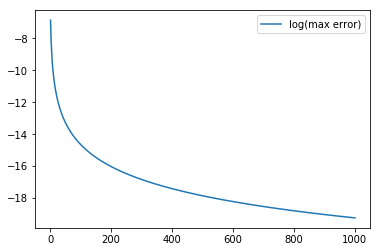

In [292]:
n_from = 1
n_to = 1000

ns = list(range(n_from, n_to + 1))
errors = list(map(lambda n: max(get_errors(solve_linalg, n)), ns))

ns = np.array(ns)
errors = np.array(errors)

errors = np.log(errors)

draw(ns, errors, "log(max error)")

График ошибки выглядит, как гипербола. То есть из графика можно предположить, что ошибка убывает как $\frac{1}{n^\alpha}$.

Реализуем метод прогонки.

In [293]:
def tridiag(mA, vb):
    n = len(vb)
    a = [0] + [-mA[i + 1][i] for i in range(n - 1)]
    c = [mA[i][i] for i in range(n)]
    b = [-mA[i - 1][i] for i in range(1, n)]
    
    if n == 1:
        return [vb[0] / c[0]]
    
    aa = [b[0] / c[0]]
    for i in range(1, n - 1):
        aa.append(b[i] / (c[i] - aa[i - 1] * a[i]))
    
    ab = [vb[0] / c[0]]
    for i in range(1, n):
        ab.append((vb[i] + ab[i - 1] * a[i]) / (c[i] - aa[i - 1] * a[i]))
        
    res = ab.copy()
    for k in reversed(range(0, n - 1)):
        res[k] += aa[k] * res[k + 1]
        
    return res

def solve_tridiag(n):
    A = get_A(n)
    b = get_b(n)
    return tridiag(A, b)

Научимся замерять время.

In [294]:
def get_time(solve_method, A, b):
    t = time.time()
    solve_method(A, b)
    return time.time() - t

Сравним время работу методов в зависимости от $n$.

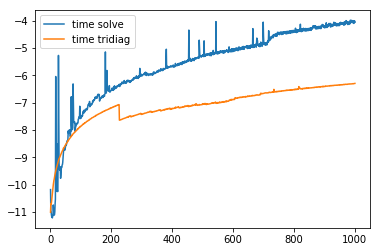

In [295]:
n_from = 1
n_to = 1000

ns = list(range(n_from, n_to + 1))
time_solve = list(map(lambda n: get_time(linalg, get_A(n), get_b(n)), ns))
time_tridiag = list(map(lambda n: get_time(tridiag, get_A(n), get_b(n)), ns))

ns = [ns] * 2
times = [time_solve, time_tridiag]
names = ["time solve", "time tridiag"]

times = np.array(times)
times = np.log(times)

draw(ns, times, names)

Из графиков видно, что метод прогонки работает быстрее стандартного примерно на два порядка. Реализация метода прогонки работает за $O(n)$. Значит можно предположить, что стандартный метод имеет время работы $O(n^3)$.

# Задание 8

Реализуем метод последовательной верхней релаксации.

In [296]:
def SOR(A, b, w):
    diag = np.diag(np.diag(A))
    lower = np.tril(A, -1)
    upper = np.triu(A, 1)
    inv = np.linalg.inv(diag + w * lower)
    T = np.matmul(inv, ((1 - w) * diag - w * upper))
    x = np.zeros(len(b))
    xs = []
    for i in range(N_GRAPH):
        x = np.matmul(T, x) + w * np.matmul(inv, b)
        xs.append(x)
    return xs

def solve_SOR(n, w):
    A = get_A(n)
    b = get_b(n)
    return SOR(A, b, w)

def get_solve_SOR(n, w):
    def foo(n):
        return solve_SOR(n, w)
    return foo

def get_SOR_max_errors(n, w, solve_method):
    xs = solve_SOR(n, w)
    rx = solve_method(n)
    max_errors = []
    for x in xs:
        max_errors.append(max(get_diff(list(range(n)), 
                                       lambda i: x[i],
                                       lambda i: rx[i])))
    return max_errors

In [297]:
ws = [1, 1.3, 1.6, 1.8, 1.9]

Посмотрим на зависимость погрешности от номера итерации.

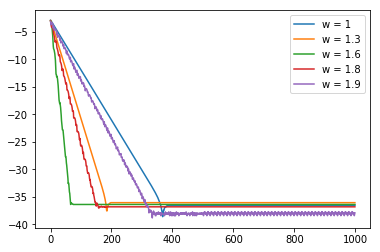

In [298]:
n = 10

itrs = list(range(N_GRAPH))
all_max_errors = []
names = []
for w in ws:
    max_errors = get_SOR_max_errors(n, w, solve_tridiag)
    all_max_errors.append(max_errors)
    names.append("w = " + str(w))
    
itrs = [itrs] * len(all_max_errors)
all_max_errors = np.array(all_max_errors)
all_max_errors = np.log(all_max_errors)

draw(itrs, all_max_errors, names)

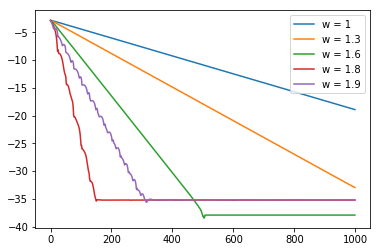

In [299]:
n = 25

itrs = list(range(N_GRAPH))
all_max_errors = []
names = []
for w in ws:
    max_errors = get_SOR_max_errors(n, w, solve_tridiag)
    all_max_errors.append(max_errors)
    names.append("w = " + str(w))
    
itrs = [itrs] * len(all_max_errors)
all_max_errors = np.array(all_max_errors)
all_max_errors = np.log(all_max_errors)

draw(itrs, all_max_errors, names)

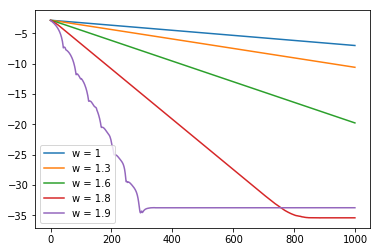

In [300]:
n = 50

itrs = list(range(N_GRAPH))
all_max_errors = []
names = []
for w in ws:
    max_errors = get_SOR_max_errors(n, w, solve_tridiag)
    all_max_errors.append(max_errors)
    names.append("w = " + str(w))
    
itrs = [itrs] * len(all_max_errors)
all_max_errors = np.array(all_max_errors)
all_max_errors = np.log(all_max_errors)

draw(itrs, all_max_errors, names)

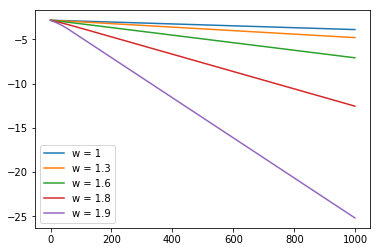

In [301]:
n = 100

itrs = list(range(N_GRAPH))
all_max_errors = []
names = []
for w in ws:
    max_errors = get_SOR_max_errors(n, w, solve_tridiag)
    all_max_errors.append(max_errors)
    names.append("w = " + str(w))
    
itrs = [itrs] * len(all_max_errors)
all_max_errors = np.array(all_max_errors)
all_max_errors = np.log(all_max_errors)

draw(itrs, all_max_errors, names)

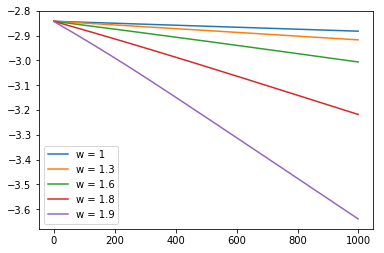

In [302]:
n = 500

itrs = list(range(N_GRAPH))
all_max_errors = []
names = []
for w in ws:
    max_errors = get_SOR_max_errors(n, w, solve_tridiag)
    all_max_errors.append(max_errors)
    names.append("w = " + str(w))
    
itrs = [itrs] * len(all_max_errors)
all_max_errors = np.array(all_max_errors)
all_max_errors = np.log(all_max_errors)

draw(itrs, all_max_errors, names)

Как видно, погрешность убывает експоненциально по мере увелечения итерации. При достаточно больших $n$, $\omega = 1.9$ имеет наименьшую погрешность. Также стоит отметить, что при увелечение $n$, при прочих равных, погрешность увеличивается.